### CS 145: Final Project EDA

In [19]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind

In [1]:
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

train_author = load_json('train_author.json')
pid_to_info_all = load_json('pid_to_info_all.json')
ind_valid_author = load_json('ind_valid_author.json')


In [16]:
# Extract author and paper IDs from train_author
train_author_ids = set(train_author.keys())
train_paper_ids = {paper_id for author_info in train_author.values() for paper_id in author_info.get('normal_data', []) + author_info.get('outliers', [])}

# Extract author and paper IDs from ind_valid_author
valid_author_ids = set(ind_valid_author.keys())
valid_paper_ids = {paper_id for author_info in ind_valid_author.values() for paper_id in author_info.get('papers', [])}

# Extract paper IDs from pid_to_info_all
all_paper_ids = set(pid_to_info_all.keys())

# Calculate the percentage of author IDs
author_overlap = train_author_ids & valid_author_ids
author_percentage = len(author_overlap) / len(train_author_ids) * 100

# Calculate the percentage of paper IDs
paper_overlap_valid = train_paper_ids & valid_paper_ids
paper_percentage_valid = len(paper_overlap_valid) / len(train_paper_ids) * 100

paper_overlap_all = train_paper_ids & all_paper_ids
paper_percentage_all = len(paper_overlap_all) / len(train_paper_ids) * 100

# Print the results
print(f"Percentage of author IDs in the validation set: {author_percentage:.2f}%")
print(f"Percentage of paper IDs in the validation set: {paper_percentage_valid:.2f}%")
print(f"Percentage of paper IDs in the all papers set: {paper_percentage_all:.2f}%")

Percentage of author IDs in the validation set: 0.00%
Percentage of paper IDs in the validation set: 1.86%
Percentage of paper IDs in the all papers set: 100.00%


This means all the papers in the validation set are also present with information in the given `pid_to_info_all.json` dataset.

         num_authors           year
count  148309.000000  148309.000000
mean       13.674612    1996.129223
std       122.252832     168.660281
min         0.000000       0.000000
25%         3.000000    2007.000000
50%         5.000000    2011.000000
75%         7.000000    2016.000000
max      6530.000000    2024.000000


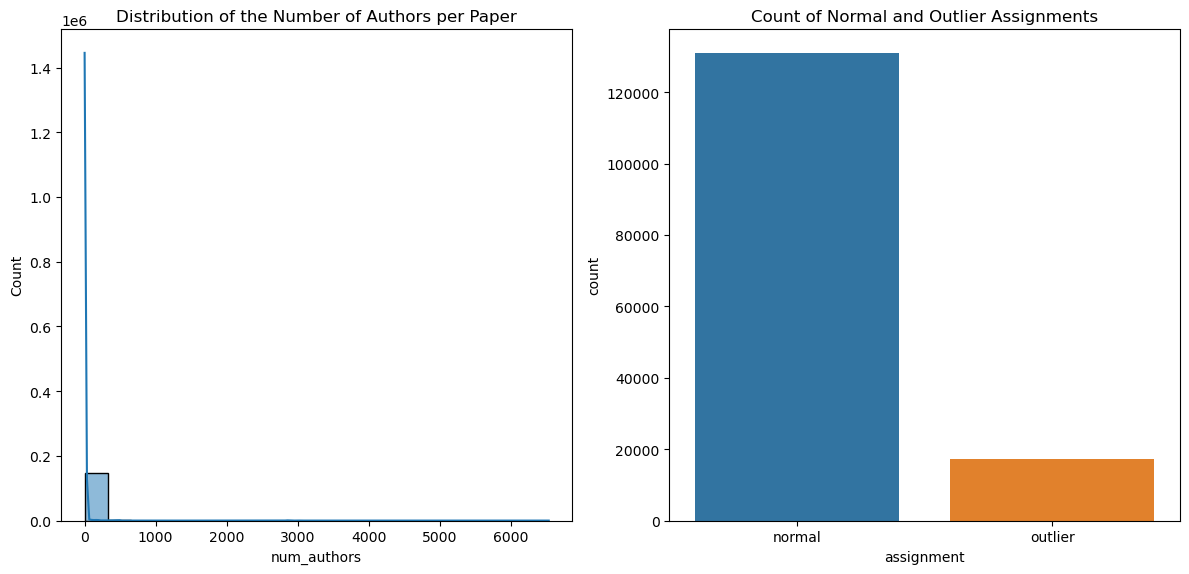

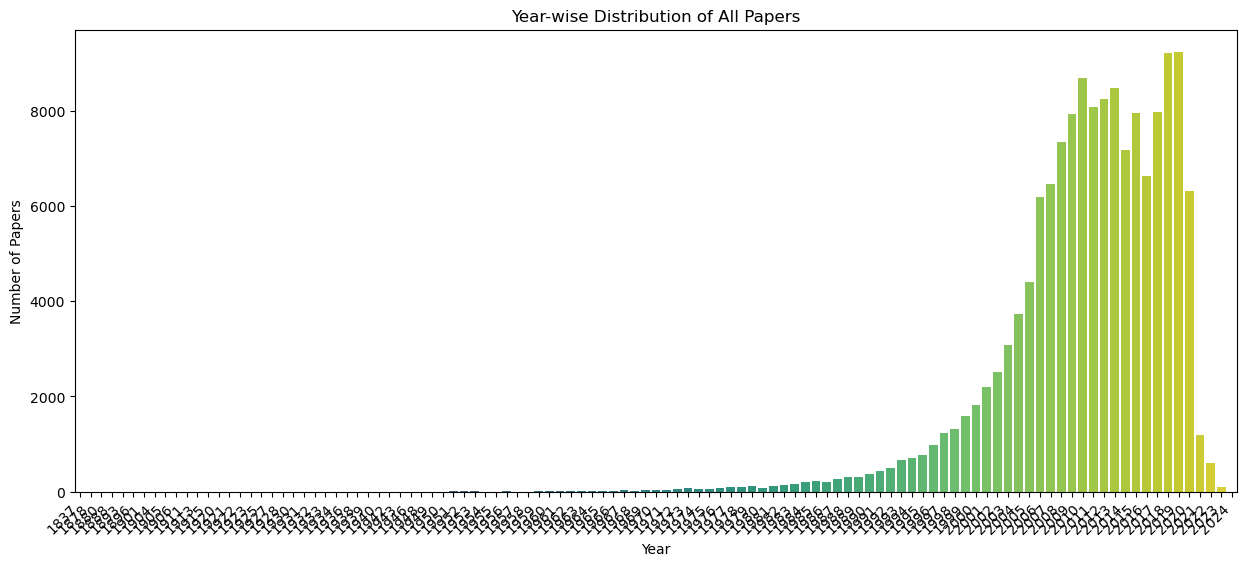

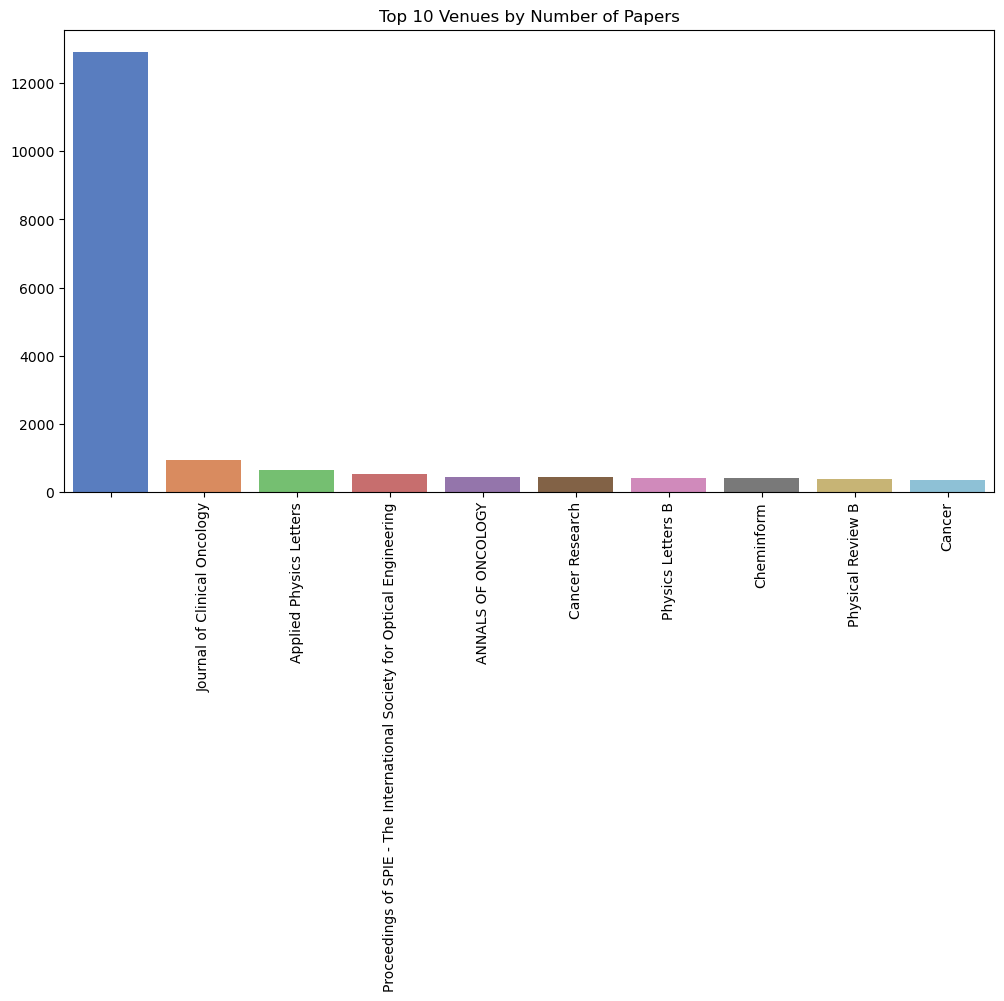

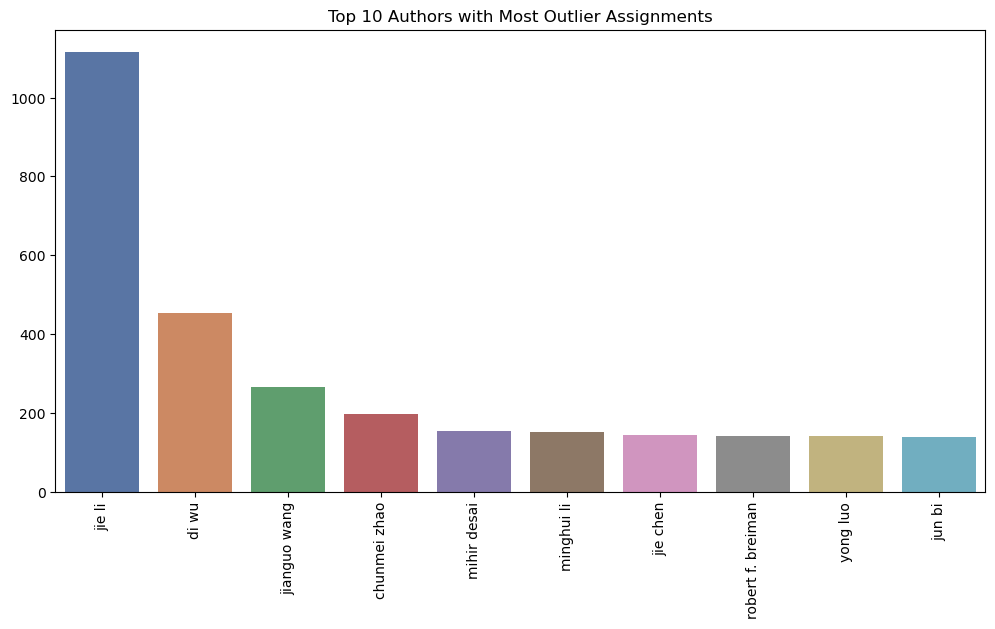

In [22]:
# Convert JSON data to pandas DataFrames
def create_author_df(author_data):
    data = []
    for author_id, info in author_data.items():
        for paper_id in info.get('normal_data', []):
            data.append([author_id, info['name'], paper_id, 'normal'])
        for paper_id in info.get('outliers', []):
            data.append([author_id, info['name'], paper_id, 'outlier'])
    return pd.DataFrame(data, columns=['author_id', 'author_name', 'paper_id', 'assignment'])

def create_paper_df(paper_data):
    data = []
    for paper_id, info in paper_data.items():
        year = info.get('year', 0)
        if not isinstance(year, int):
            try:
                year = int(year)
            except ValueError:
                year = 0
        data.append([paper_id, info['title'], len(info['authors']), info.get('venue', ''), year, info.get('keywords', [])])
    return pd.DataFrame(data, columns=['paper_id', 'title', 'num_authors', 'venue', 'year', 'keywords'])

author_df = create_author_df(train_author)
paper_df = create_paper_df(pid_to_info_all)

# Merge DataFrames to get a complete view
merged_df = author_df.merge(paper_df, on='paper_id')

# Display basic statistics
print(merged_df.describe())

# Visualizations
plt.figure(figsize=(12, 6))

# Distribution of the number of authors per paper
plt.subplot(1, 2, 1)
sns.histplot(merged_df['num_authors'], bins=20, kde=True)
plt.title('Distribution of the Number of Authors per Paper')

# Count of normal and outlier assignments
plt.subplot(1, 2, 2)
sns.countplot(x='assignment', data=merged_df)
plt.title('Count of Normal and Outlier Assignments')

plt.tight_layout()
plt.show()

# Year-wise distribution of papers
plt.figure(figsize=(15, 6))
merged_df = merged_df[merged_df['year'] > 0]  # Filter out invalid years
sorted_merged_df = merged_df.sort_values(by='year')
sns.countplot(x='year', data=sorted_merged_df, palette='viridis', order=sorted_merged_df['year'].unique())
plt.title('Year-wise Distribution of All Papers')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.show()

# Top 10 venues by number of papers
top_venues = merged_df['venue'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_venues.index, y=top_venues.values, palette='muted')
plt.title('Top 10 Venues by Number of Papers')
plt.xticks(rotation=90)
plt.show()

# Authors with most outlier assignments
outliers_df = merged_df[merged_df['assignment'] == 'outlier']
top_outliers_authors = outliers_df['author_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_outliers_authors.index, y=top_outliers_authors.values, palette='deep')
plt.title('Top 10 Authors with Most Outlier Assignments')
plt.xticks(rotation=90)
plt.show()


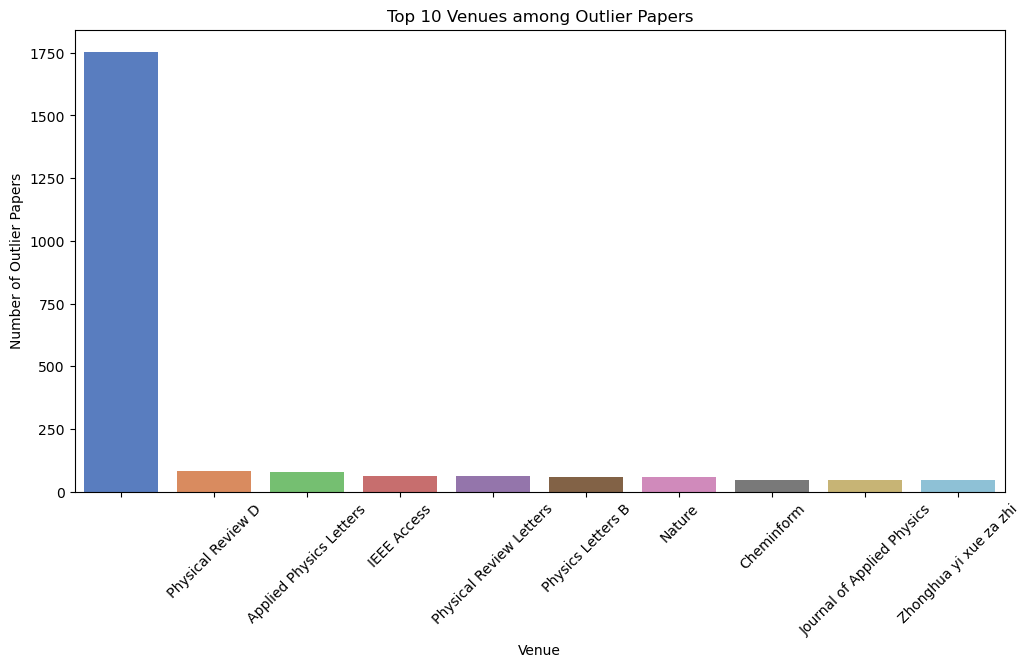

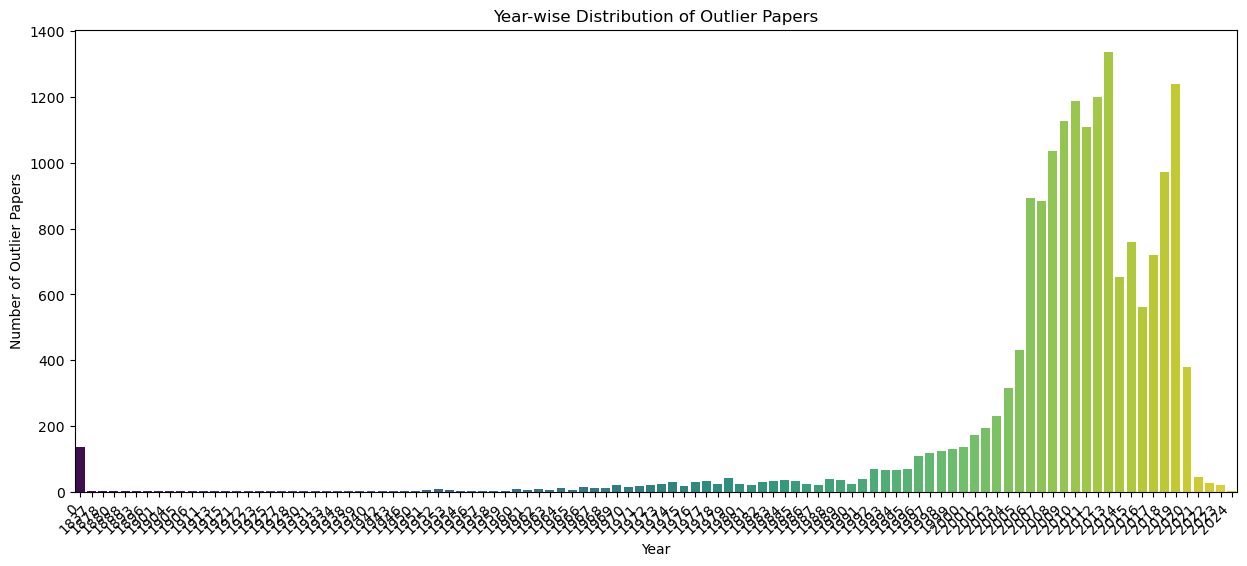

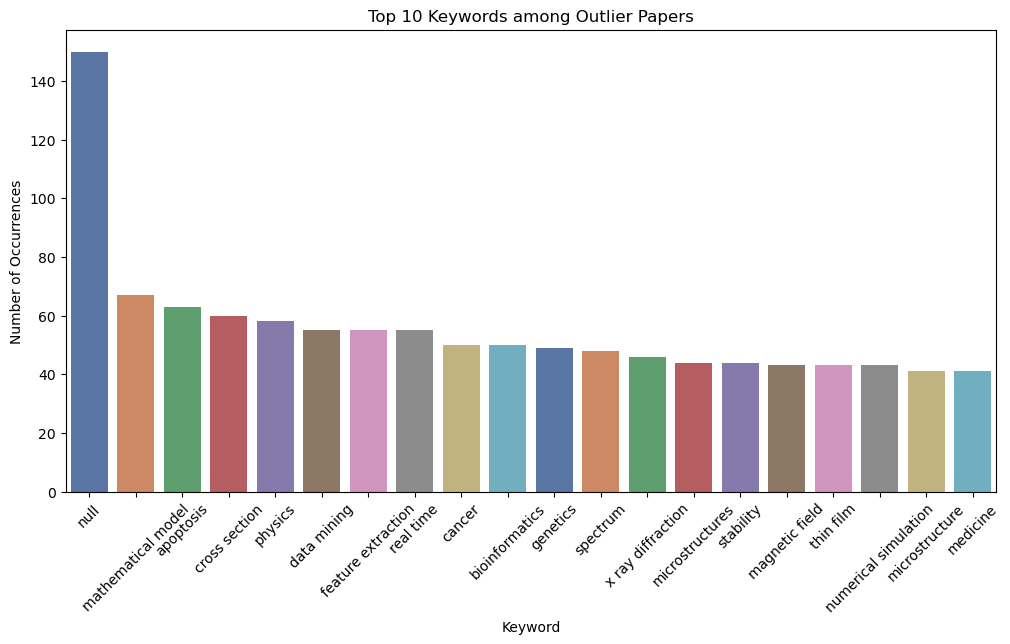

In [12]:
# Filter for outliers
outliers_df = merged_df[merged_df['assignment'] == 'outlier']

# Visualization: Top 10 venues among outlier papers
top_outlier_venues = outliers_df['venue'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_outlier_venues.index, y=top_outlier_venues.values, palette='muted')
plt.title('Top 10 Venues among Outlier Papers')
plt.xticks(rotation=45)
plt.ylabel('Number of Outlier Papers')
plt.xlabel('Venue')
plt.show()

# Visualization: Year-wise distribution of outlier papers
plt.figure(figsize=(15, 6))
sorted_outliers_df = outliers_df.sort_values(by='year')
sns.countplot(x='year', data=sorted_outliers_df, palette='viridis', order=sorted_outliers_df['year'].unique())
plt.title('Year-wise Distribution of Outlier Papers')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Outlier Papers')
plt.show()

# Visualization: Top 10 keywords among outlier papers
from collections import Counter

all_keywords = [keyword for sublist in outliers_df['keywords'] for keyword in sublist]
top_outlier_keywords = dict(Counter(all_keywords).most_common(20))
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_outlier_keywords.keys()), y=list(top_outlier_keywords.values()), palette='deep')
plt.title('Top 10 Keywords among Outlier Papers')
plt.xticks(rotation=45)
plt.ylabel('Number of Occurrences')
plt.xlabel('Keyword')
plt.show()

In [13]:
outliers_df.head()

,author_id,author_name,paper_id,assignment,title,num_authors,venue,year,keywords
590,Iki037dt,atsushi ochiai,XL3wd3CP,outlier,Heavy fermion behavior in electrical resistivi...,5,Fuel and Energy Abstracts,2007,"[electrical resistance, superconductors, heavy..."
591,Iki037dt,atsushi ochiai,BTKTiJp2,outlier,Structures of Li 2 MnO 3 for lithium battery e...,5,Acta Crystallographica Section A,2008,[]
592,Iki037dt,atsushi ochiai,JxSjl5xc,outlier,"ChemInform Abstract: JBIR-17, a Novel Trichost...",9,Cheminform,2009,[]
593,Iki037dt,atsushi ochiai,0jyMLgRt,outlier,Crystalline-electric field of Pr ( Os 1 - x Ru...,3,Journal of Analytical and Applied Pyrolysis,2006,"[functional form, single crystal, ground state..."
594,Iki037dt,atsushi ochiai,uHWx8D2u,outlier,Size control of calcium alginate beads contain...,8,Biomaterials,2005,"[Alginate, Cell encapsulation, Microcapsule, M..."


In [15]:
merged_df.head()

,author_id,author_name,paper_id,assignment,title,num_authors,venue,year,keywords
0,Iki037dt,atsushi ochiai,YzOCpPTO,normal,THE POWER OF THE HIGH-SENSITIVE KRAS TEST TO P...,14,ANNALS OF ONCOLOGY,2010,
1,Iki037dt,atsushi ochiai,AblgcGjH,normal,1812 NICARDIPINE VERSUS SALINE INJECTION AS TR...,8,The Journal of Urology,2011,[]
2,Iki037dt,atsushi ochiai,B5aouLse,normal,Possible use of ultrasound estimated bladder w...,9,Ultrasound in medicine & biology,2001,"[vesicoureteral reflux, bladder hypertrophy, c..."
3,Iki037dt,atsushi ochiai,u1G7wBEv,normal,Interaction between epidermal growth factor an...,10,Journal of Steroid Biochemistry,1987,[]
4,Iki037dt,atsushi ochiai,W7w6P8lA,normal,Comprehensive Analyses Using Next-Generation S...,10,Annals of Oncology,2015,"[gastric cancer, amplification, mutation, next..."


In [18]:
merged_df.assignment.value_counts(normalize=True)*100

normal     88.345279
outlier    11.654721
Name: assignment, dtype: float64

Descriptive statistics for normal papers:
       author_id author_name  paper_id assignment   title    num_authors  \
count     130110      130110    130110     130110  130110  130110.000000   
unique       779         756    127121          1  119941            NaN   
top     jtyzCugY    jie chen  M02owKzz     normal                    NaN   
freq        2383        2383         4     130110    5620            NaN   
mean         NaN         NaN       NaN        NaN     NaN      11.915510   
std          NaN         NaN       NaN        NaN     NaN     105.502451   
min          NaN         NaN       NaN        NaN     NaN       0.000000   
25%          NaN         NaN       NaN        NaN     NaN       3.000000   
50%          NaN         NaN       NaN        NaN     NaN       5.000000   
75%          NaN         NaN       NaN        NaN     NaN       7.000000   
max          NaN         NaN       NaN        NaN     NaN    6530.000000   

         venue           year keywords  
coun

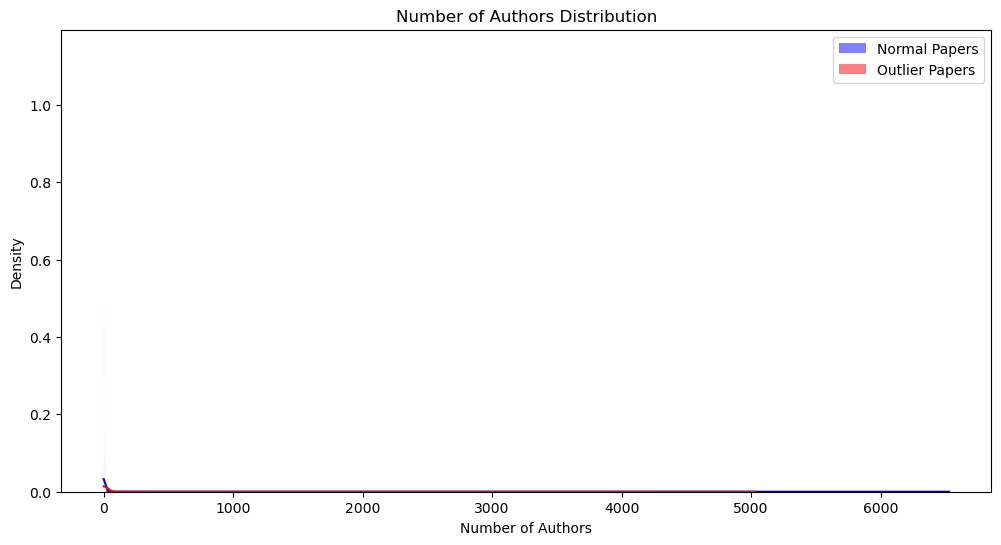

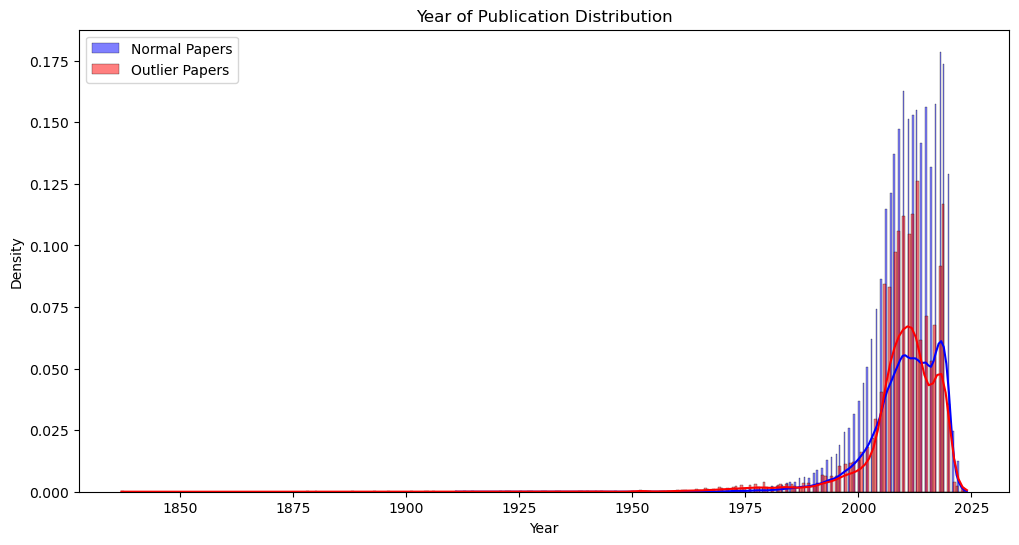

/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32479 (\N{CJK UNIFIED IDEOGRAPH-7EDF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33258 (\N{CJK UNIF

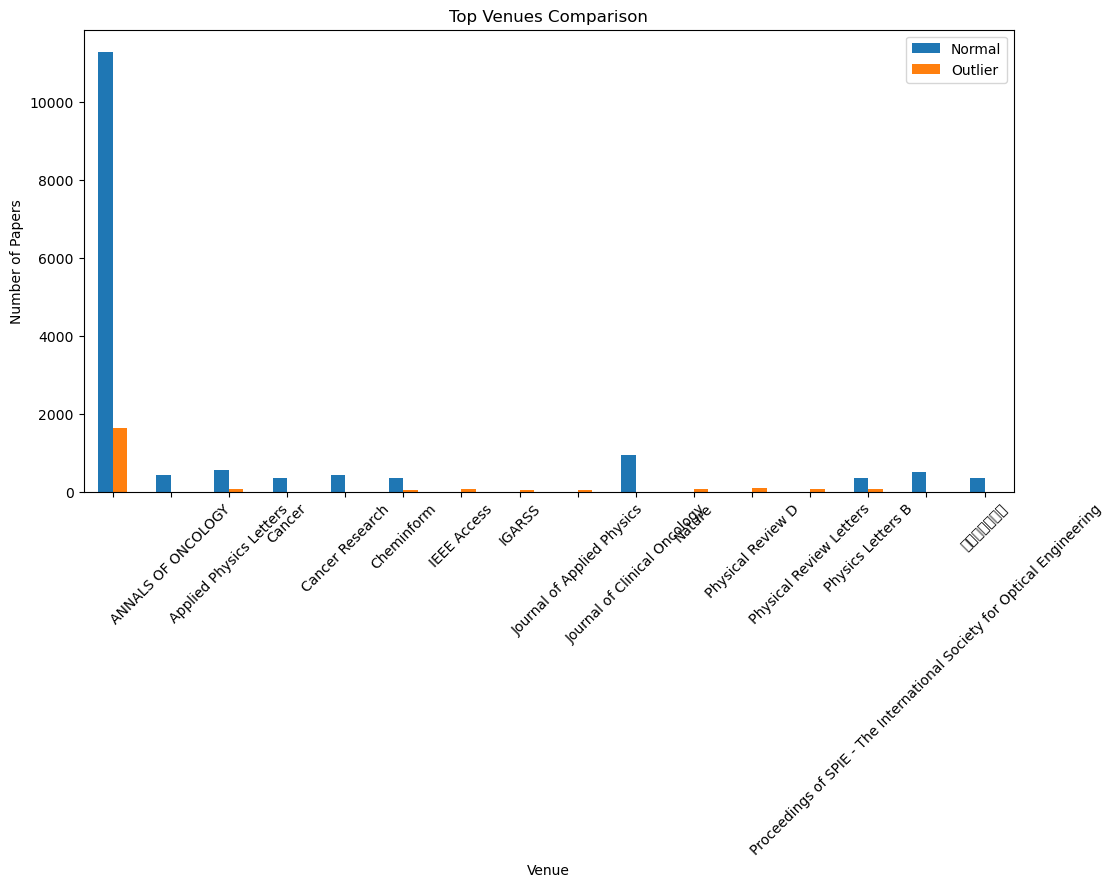

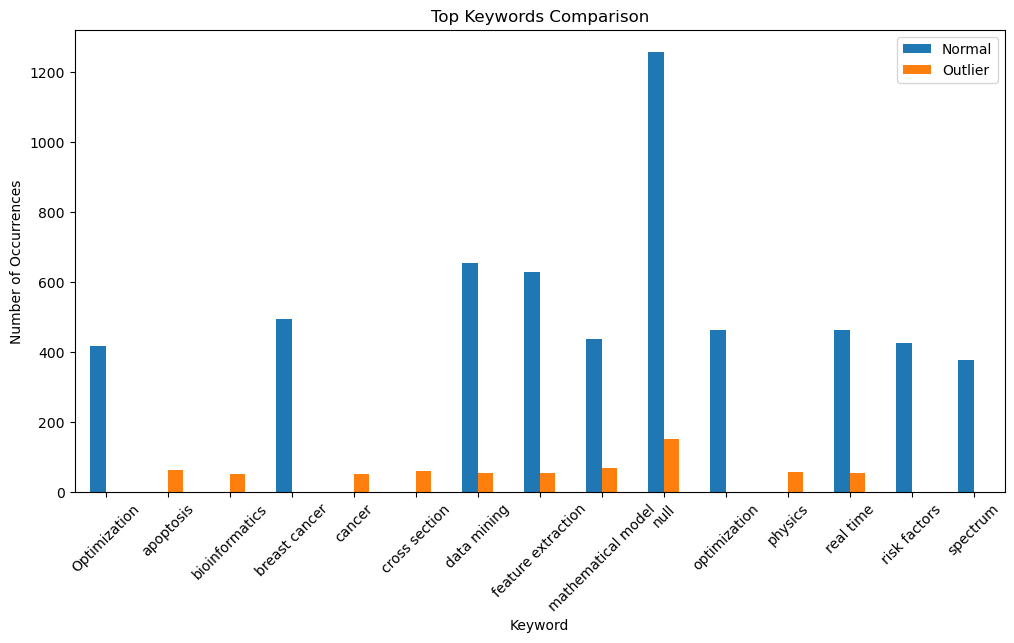

Chi-square test for venues: chi2 = 50050.49, p-value = 0.0000
T-test for number of authors: t-statistic = -8.46, p-value = 0.0000
T-test for year of publication: t-statistic = 13.85, p-value = 0.0000


In [23]:
# Separate normal and outlier papers
normal_papers_df = merged_df[merged_df['assignment'] == 'normal']

# Descriptive statistics
print("Descriptive statistics for normal papers:")
print(normal_papers_df.describe(include='all'))

print("\nDescriptive statistics for outlier papers:")
print(outliers_df.describe(include='all'))

# Visualization: Number of authors
plt.figure(figsize=(12, 6))
sns.histplot(normal_papers_df['num_authors'], color='blue', label='Normal Papers', kde=True, stat="density", common_norm=False)
sns.histplot(outliers_df['num_authors'], color='red', label='Outlier Papers', kde=True, stat="density", common_norm=False)
plt.title('Number of Authors Distribution')
plt.xlabel('Number of Authors')
plt.legend()
plt.show()

# Visualization: Year of publication
plt.figure(figsize=(12, 6))
sns.histplot(normal_papers_df['year'], color='blue', label='Normal Papers', kde=True, stat="density", common_norm=False)
sns.histplot(outliers_df['year'], color='red', label='Outlier Papers', kde=True, stat="density", common_norm=False)
plt.title('Year of Publication Distribution')
plt.xlabel('Year')
plt.legend()
plt.show()

# Visualization: Venues
top_normal_venues = normal_papers_df['venue'].value_counts().head(10)
top_outlier_venues = outliers_df['venue'].value_counts().head(10)
venues_df = pd.DataFrame({
    'Normal': top_normal_venues,
    'Outlier': top_outlier_venues
}).fillna(0)

venues_df.plot(kind='bar', figsize=(12, 6))
plt.title('Top Venues Comparison')
plt.xlabel('Venue')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.show()

# Visualization: Keywords
from collections import Counter

def get_top_keywords(papers_df, top_n=10):
    all_keywords = [keyword for sublist in papers_df['keywords'] for keyword in sublist]
    return dict(Counter(all_keywords).most_common(top_n))

top_normal_keywords = get_top_keywords(normal_papers_df)
top_outlier_keywords = get_top_keywords(outliers_df)

keywords_df = pd.DataFrame({
    'Normal': pd.Series(top_normal_keywords),
    'Outlier': pd.Series(top_outlier_keywords)
}).fillna(0)

keywords_df.plot(kind='bar', figsize=(12, 6))
plt.title('Top Keywords Comparison')
plt.xlabel('Keyword')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

# Statistical tests
# Chi-square test for venues
contingency_table = pd.crosstab(merged_df['venue'], merged_df['assignment'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test for venues: chi2 = {chi2:.2f}, p-value = {p:.4f}")

# T-test for number of authors
t_stat, p_val = ttest_ind(normal_papers_df['num_authors'], outliers_df['num_authors'], equal_var=False)
print(f"T-test for number of authors: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# T-test for year of publication
t_stat, p_val = ttest_ind(normal_papers_df['year'], outliers_df['year'], equal_var=False)
print(f"T-test for year of publication: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")